<a href="https://colab.research.google.com/github/alvinrach/SmartFarmingTemporaryTransit/blob/main/Univariate_each_loss_IoTsccic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!pip install PyMySQL
import json
from sqlalchemy import create_engine

# open connection to the db
json_path = '/content/drive/MyDrive/lppm-itb-iot-anomaly/paper/config_colab.json'
# json_path = './config.json'

with open(json_path) as json_file:
    config = json.load(json_file)

db_connection_str = "mysql+pymysql://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_db}".format(
mysql_user = config['database']['username'], 
mysql_password = config['database']['password'],
mysql_host = config['database']['host'],
mysql_db = config['database']['databasename']
    
)
db_connection = create_engine(db_connection_str)

In [5]:
df = pd.read_sql('SELECT * FROM temp_suhus', con=db_connection)
df.head()

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
0,1,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,36.3,NaN,36.20,2020-10-16 18:55:37,2020-10-16 18:55:37
1,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
3,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,71.6,NaN,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
4,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01


In [6]:
# convert timestamp
df['timestamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')

In [7]:
df['batv'].interpolate(method='linear', direction = 'forward', inplace=True)
df['hum_sht'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_ds'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_sht'].interpolate(method='linear', direction = 'forward', inplace=True)

In [8]:
df = df.dropna()
df.isna().sum()

id            0
app_id        0
dev_id        0
eui           0
batv          0
hum_sht       0
tempc_ds      0
tempc_sht     0
created_at    0
updated_at    0
timestamp     0
dtype: int64

In [9]:
df.set_index(['timestamp'], inplace=False)

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
timestamp,,,,,,,,,,
2020-10-16 19:02:02,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2020-10-16 19:32:02,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
2020-10-16 19:55:39,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,3.067,71.6,26.34,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
2020-10-16 20:02:01,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01
2020-10-16 20:32:02,6,lora-lht65,lht65-1,A84041000181B265,3.068,79.1,22.93,24.54,2020-10-16 20:32:02,2020-10-16 20:32:02
...,...,...,...,...,...,...,...,...,...,...
2021-07-19 11:21:31,35825,lora-lht65,lht65-1,A84041000181B265,3.057,47.1,34.31,38.66,2021-07-19 11:21:31,2021-07-19 11:21:31
2021-07-19 11:50:34,35826,lora-lht65,lht65-2,A84041000181B266,3.051,37.5,40.56,42.42,2021-07-19 11:50:34,2021-07-19 11:50:34
2021-07-19 11:51:15,35827,lora-lht65,lht65-3,A84041000181B267,3.054,37.2,40.50,43.38,2021-07-19 11:51:15,2021-07-19 11:51:15


In [10]:
df_ = df.resample('20Min', on='timestamp').mean()

In [11]:
df_ = df_[['batv', 'hum_sht', 'tempc_ds', 'tempc_sht']]
df_.head()

,batv,hum_sht,tempc_ds,tempc_sht
timestamp,,,,
2020-10-16 19:00:00,3.064,21.0,50.00,53.61
2020-10-16 19:20:00,3.066,45.4,29.31,34.68
2020-10-16 19:40:00,3.067,71.6,26.34,25.20
2020-10-16 20:00:00,3.068,65.9,23.37,27.33
2020-10-16 20:20:00,3.068,79.1,22.93,24.54


In [12]:
df_ = df_.dropna()

In [13]:
# key cell
df = df_.copy()

In [14]:
df

,batv,hum_sht,tempc_ds,tempc_sht
timestamp,,,,
2020-10-16 19:00:00,3.064000,21.000000,50.000000,53.610000
2020-10-16 19:20:00,3.066000,45.400000,29.310000,34.680000
2020-10-16 19:40:00,3.067000,71.600000,26.340000,25.200000
2020-10-16 20:00:00,3.068000,65.900000,23.370000,27.330000
2020-10-16 20:20:00,3.068000,79.100000,22.930000,24.540000
...,...,...,...,...
2021-07-19 10:40:00,3.051667,43.866667,35.873333,40.393333
2021-07-19 11:00:00,3.050000,52.600000,38.030000,32.900000
2021-07-19 11:20:00,3.052667,42.700000,37.850000,40.670000


In [15]:
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4'])

In [16]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = list(df.columns)
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
principalDf = df[most_important_names]
most_important_names

['hum_sht', 'tempc_sht', 'tempc_ds', 'batv']

In [17]:
train_data, test_data = train_test_split(principalDf, shuffle=False, test_size=0.3)

In [18]:
scaler = MinMaxScaler()
scaler.fit(principalDf)
X_trainset = scaler.transform(train_data)
X_testset = scaler.transform(test_data)

In [19]:
X_trainset = pd.DataFrame(X_trainset)
X_testset = pd.DataFrame(X_testset)

In [20]:
epo = 60

In [78]:
tr_set = X_trainset.iloc[:,0:1]
ts_set = X_testset.iloc[:,0:1]

TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(tr_set, tr_set)
X_test, y_test = create_sequences(ts_set, ts_set)

In [79]:
def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

In [80]:
model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                912       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [81]:
nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

Epoch 1/60
318/318 [==============================] - 4s 5ms/step - loss: 1.6226e-04 - val_loss: 2.6562e-04
Epoch 2/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2925e-04 - val_loss: 2.6359e-04
Epoch 3/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2543e-04 - val_loss: 2.6486e-04
Epoch 4/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2442e-04 - val_loss: 2.6558e-04
Epoch 5/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2376e-04 - val_loss: 2.6524e-04
Epoch 6/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2312e-04 - val_loss: 2.6427e-04
Epoch 7/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2247e-04 - val_loss: 2.6307e-04
Epoch 8/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2182e-04 - val_loss: 2.6178e-04
Epoch 9/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2116e-04 - val_loss: 2.6047e-04
Epoch 10/60
318/318 [=======

In [82]:
a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = y_train.copy()
y_test_1 = y_test.copy()

X_pred_tr = a.copy()
X_pred_ts = b.copy()

In [83]:
tr_set = X_trainset.iloc[:,1:2]
ts_set = X_testset.iloc[:,1:2]

TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(tr_set, tr_set)
X_test, y_test = create_sequences(ts_set, ts_set)

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 16)                912       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 4s 5ms/step - loss: 5.8912e-04 - val_loss: 2.4479e-04
Epoch 2/60
318/318 [==============================] - 1s 4ms/step - loss: 3.2028e-04 - val_loss: 2.3454e-04
Epoch 3/60
318/318 [==============================] - 1s 4ms/step - loss: 3.1915e-04 - val_loss: 2.3408e-04
Epoch 4/60
318/318 [==============================] - 1s 4ms/step - loss: 3.1864e-04 - val_loss: 2.3334e-04
Epoch 5/60
318/318 [==============================] - 1s 4ms/step - loss: 3.1810e-04 -

In [84]:
tr_set = X_trainset.iloc[:,2:3]
ts_set = X_testset.iloc[:,2:3]

TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(tr_set, tr_set)
X_test, y_test = create_sequences(ts_set, ts_set)

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 16)                912       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 4.1256e-04
Epoch 2/60
318/318 [==============================] - 1s 4ms/step - loss: 3.7842e-04 - val_loss: 2.3726e-04
Epoch 3/60
318/318 [==============================] - 1s 4ms/step - loss: 3.5096e-04 - val_loss: 2.2606e-04
Epoch 4/60
318/318 [==============================] - 1s 4ms/step - loss: 3.4103e-04 - val_loss: 2.1497e-04
Epoch 5/60
318/318 [==============================] - 1s 4ms/step - loss: 3.3176e-04 - val

In [85]:
tr_set = X_trainset.iloc[:,3:4]
ts_set = X_testset.iloc[:,3:4]

TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(tr_set, tr_set)
X_test, y_test = create_sequences(ts_set, ts_set)

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 16)                912       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 3s 5ms/step - loss: 0.0303 - val_loss: 0.0056
Epoch 2/60
318/318 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 3/60
318/318 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 4/60
318/318 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 5/60
318/318 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 9.0029e-04
Epoch 6/60
318

In [86]:
# Key cell

X_pred = X_pred_ts
y_test = scaler.inverse_transform(y_test_1)

# X_pred = X_pred_tr
# y_train = scaler.inverse_transform(y_train_1)

In [87]:
X_prediction = scaler.inverse_transform(X_pred)
# X_prediction = X_pred
output = pd.DataFrame(X_prediction, columns = most_important_names)
output

,hum_sht,tempc_sht,tempc_ds,batv
0,96.835953,20.359312,19.814310,3.040446
1,96.640366,20.447344,20.045500,3.040390
2,96.492500,20.215378,20.004730,3.043503
3,97.019951,20.168400,19.734159,3.039376
4,96.878952,20.327740,19.979467,3.040452
...,...,...,...,...
4348,58.646606,36.635082,36.646469,3.051948
4349,50.778713,37.494648,35.009750,3.051775
4350,49.700626,34.364529,36.607956,3.051663
4351,50.531105,38.426720,36.632111,3.051517


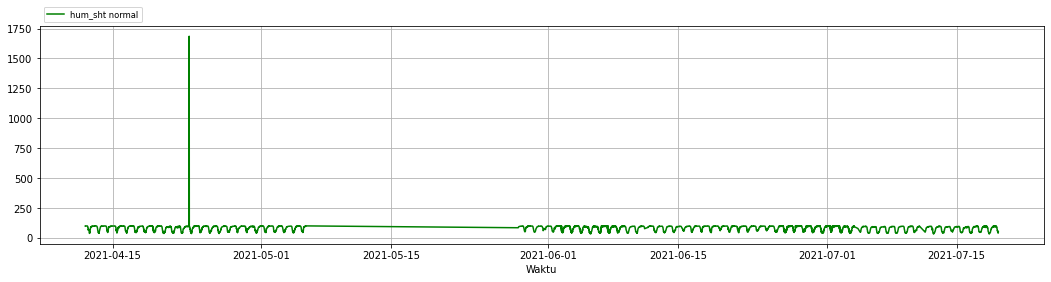

In [88]:
most_important_names
feat = most_important_names[0]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='green', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

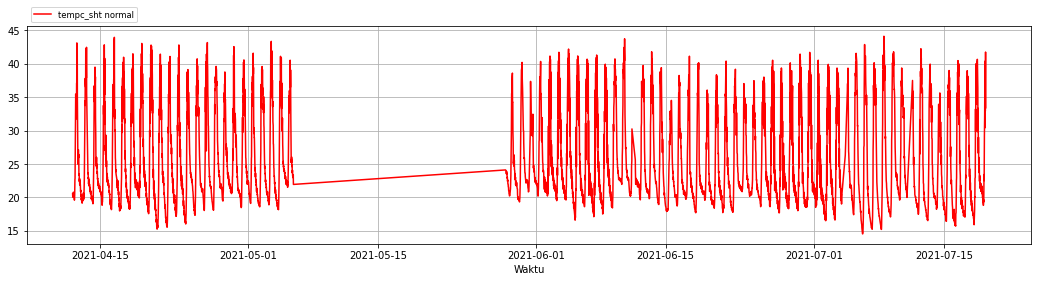

In [89]:
most_important_names
feat = most_important_names[1]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

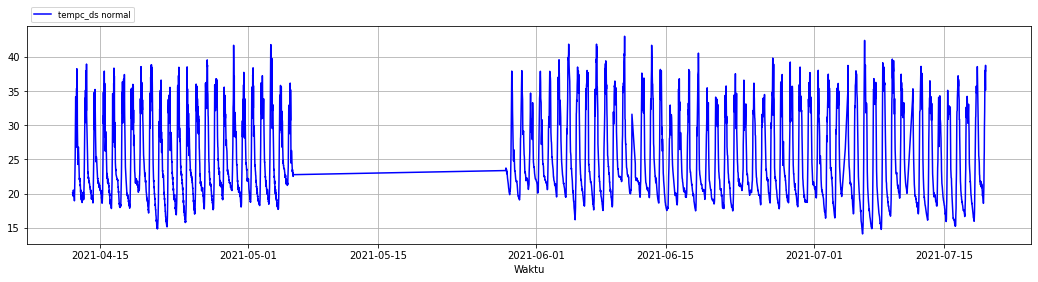

In [90]:
most_important_names
feat = most_important_names[2]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

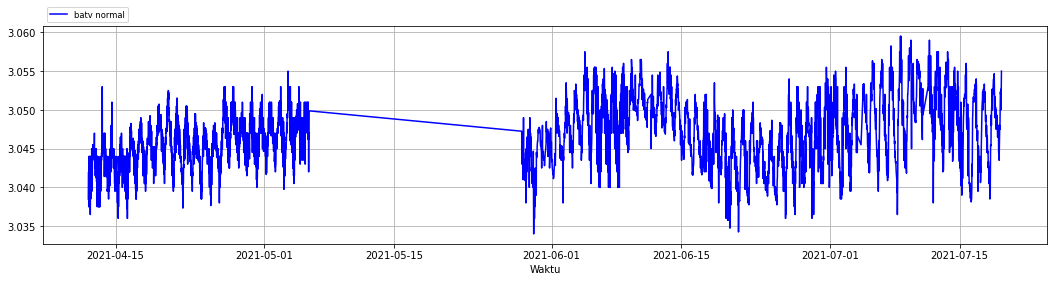

In [91]:
most_important_names
feat = most_important_names[3]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [92]:
output.index = test_data[3:].index

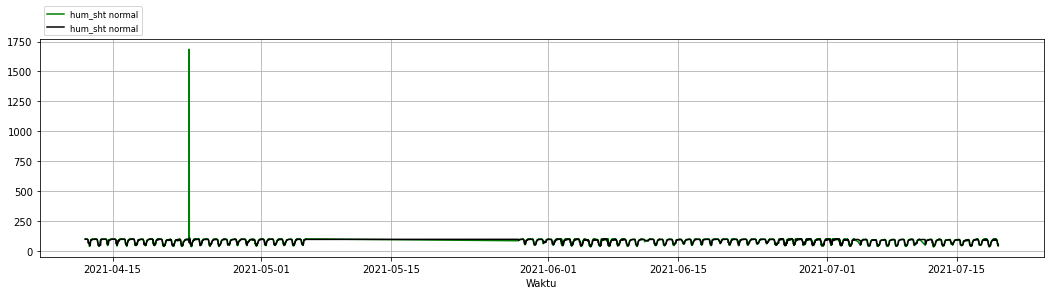

In [93]:
most_important_names
feat = most_important_names[0]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='green', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

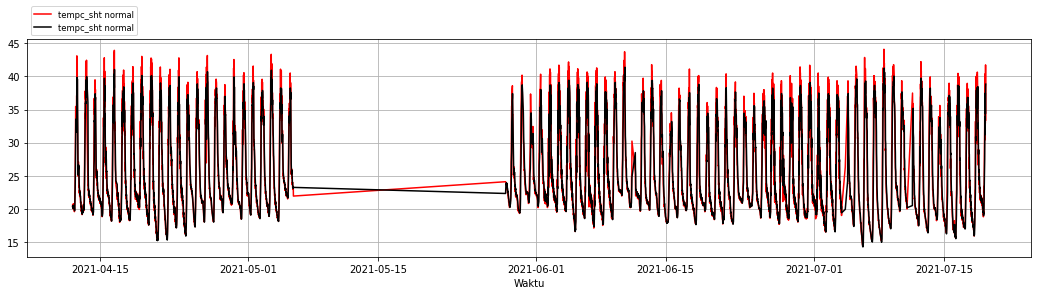

In [94]:
most_important_names
feat = most_important_names[1]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

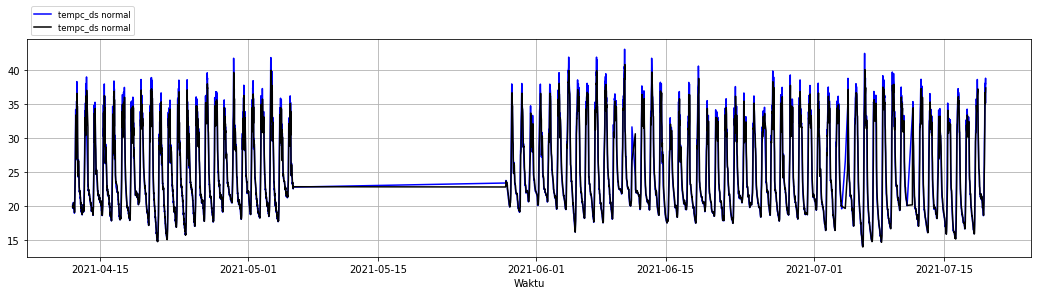

In [95]:
most_important_names
feat = most_important_names[2]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

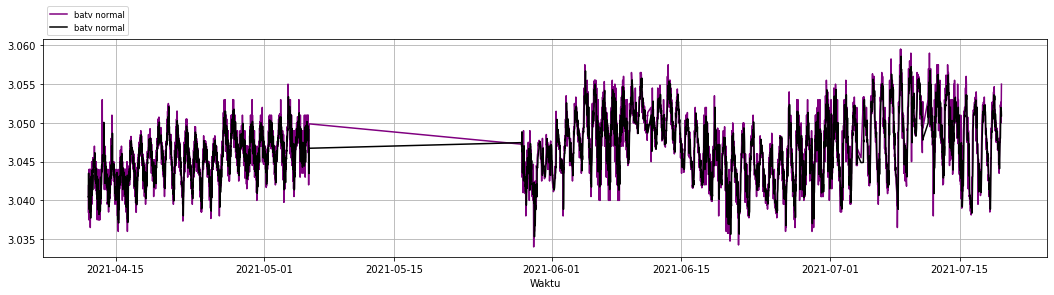

In [96]:
most_important_names
feat = most_important_names[3]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='purple', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [97]:
most_important_names
feat = most_important_names[0]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 13
data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

In [98]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Loss_mae_test'], name='Test loss'))
fig.add_trace(go.Scatter(x=data.index, y=data['Threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold -  {}'.format(feat))
fig.show()

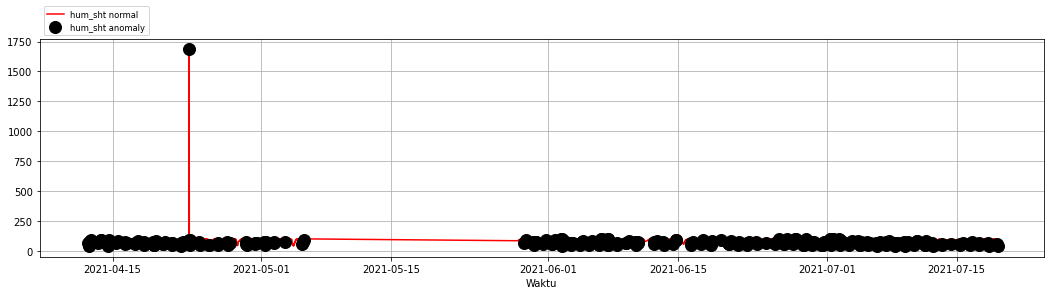

In [99]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [100]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [101]:
most_important_names
feat = most_important_names[1]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 4
data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

In [102]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Loss_mae_test'], name='Test loss'))
fig.add_trace(go.Scatter(x=data.index, y=data['Threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold -  {}'.format(feat))
fig.show()

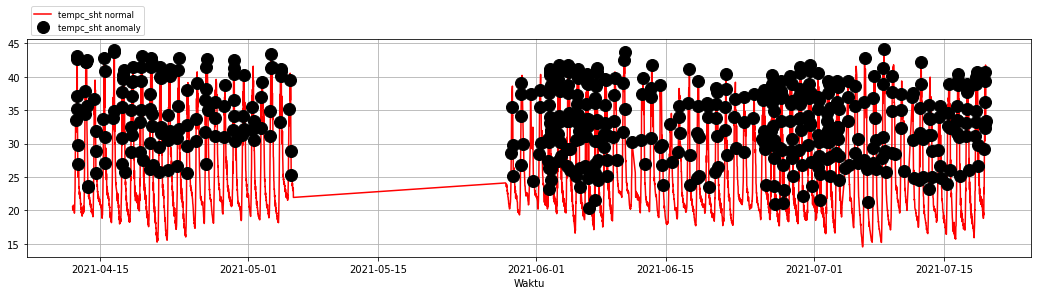

In [103]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [104]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [105]:
most_important_names
feat = most_important_names[2]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 4
data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

In [106]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Loss_mae_test'], name='Test loss'))
fig.add_trace(go.Scatter(x=data.index, y=data['Threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold -  {}'.format(feat))
fig.show()

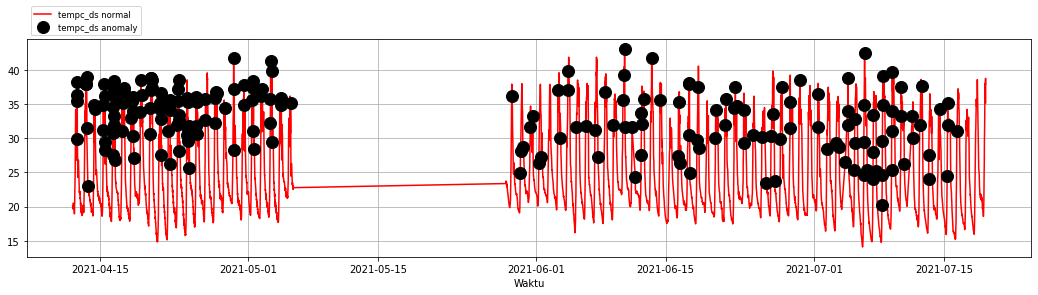

In [107]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [108]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [109]:
most_important_names
feat = most_important_names[3]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 0.006
data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

In [110]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Loss_mae_test'], name='Test loss'))
fig.add_trace(go.Scatter(x=data.index, y=data['Threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold -  {}'.format(feat))
fig.show()

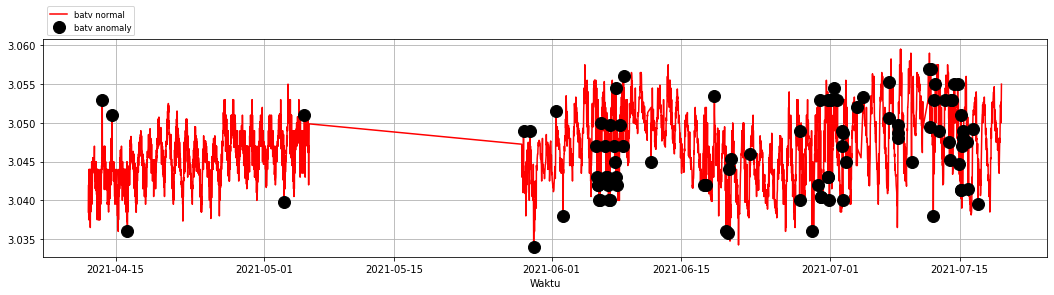

In [111]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [112]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()